# **SHROOMIFY - Image-based Disease Classification of Oyster Mushroom**

<hr>

## **Load Required Libraries**

In [ ]:
import os
import csv
import torch
import random
import shutil
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from skimage.color import rgb2gray
from torchvision.models import resnet18
from skimage.feature import graycomatrix, graycoprops
from torchvision.models import resnet18, ResNet18_Weights

<hr>

## **Pre-process Dataset**

In [ ]:
folder_path = f'dataset/'
output_csv = f'dataset.csv'
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

folder_0 = f'{folder_path}0'
folder_1 = f'{folder_path}1'
folder_2 = f'{folder_path}2'

In [ ]:
# Resize Images to 224x224

folders = [ folder_0, folder_1, folder_2]

size = (224, 224)
for folder in folders:
    files = os.listdir(folder)
    for filename in tqdm(files, desc=f"Resizing in {folder}"):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path)
            img = img.resize(size)
            img.save(file_path)
        except Exception as e:
            print(f"Skipping {file_path}: {e}")

print("Resizing images successfully.")

Resizing in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/0: 100%|██████████| 17/17 [00:04<00:00,  3.70it/s]
Resizing in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/1: 100%|██████████| 17/17 [00:06<00:00,  2.63it/s]
Resizing in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/2: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]

Resizing images successfully.


## **Data Augmentation**

In [ ]:
import os
from PIL import Image, ImageEnhance
from torchvision import transforms
from torchvision.transforms import functional as TF
from itertools import combinations
from tqdm import tqdm
import torch

def augment(folder):
    input_dir = f'{folder_path}{folder}'
    output_dir = f'{folder_path}{folder}'
    os.makedirs(output_dir, exist_ok=True)

    erasing = transforms.RandomErasing(p=1.0, scale=(0.1, 0.2), ratio=(0.5, 2.0), value=0)
    augmentations = {
        "hflip": lambda img: TF.hflip(img),
        "vflip": lambda img: TF.vflip(img),
        "rot-30": lambda img: TF.rotate(img, -30),
        "rot-15": lambda img: TF.rotate(img, -15),
        "rot15": lambda img: TF.rotate(img, 15),
        "rot30": lambda img: TF.rotate(img, 30),
        "bright": lambda img: ImageEnhance.Brightness(img).enhance(1.5),
        "contrast": lambda img: ImageEnhance.Contrast(img).enhance(1.5),
        "erase": lambda img: transforms.ToPILImage()(erasing(transforms.ToTensor()(img)))
    }

    def apply_combo(img, combo):
        for name in combo:
            img = augmentations[name](img)
        return img

    for img_name in tqdm(os.listdir(input_dir), desc="Augmenting images"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(input_dir, img_name)
        try:
            orig_img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Skipping {img_name}: {e}")
            continue

        base = os.path.splitext(img_name)[0]

        # Individual augmentations
        for name in augmentations:
            aug_img = augmentations[name](orig_img)
            aug_img.save(os.path.join(output_dir, f"{base}_{name}.jpg"))

        # Two-combo
        # for combo in combinations(augmentations, 2):
        #     aug_img = apply_combo(orig_img.copy(), combo)
        #     name_combo = '_'.join(combo)
        #     aug_img.save(os.path.join(output_dir, f"{base}_{name_combo}.jpg"))

        # Three-combo
        # for combo in combinations(augmentations, 3):
        #     aug_img = apply_combo(orig_img.copy(), combo)
        #     name_combo = '_'.join(combo)
        #     aug_img.save(os.path.join(output_dir, f"{base}_{name_combo}.jpg"))

augment(0)
augment(1)
augment(2)

Augmenting images: 100%|██████████| 17/17 [00:01<00:00,  9.50it/s]


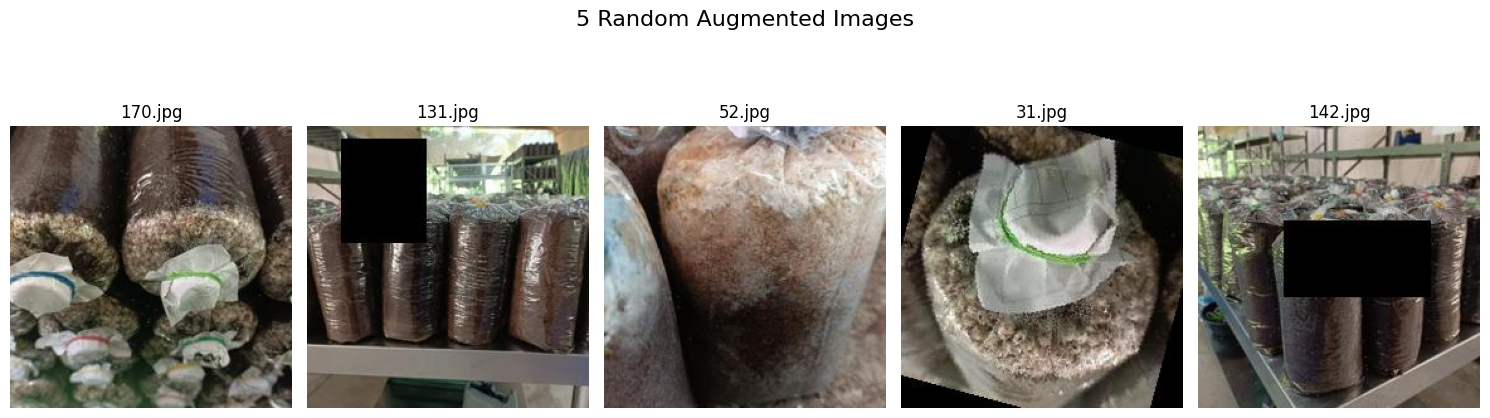

In [ ]:
augmentation_folder = f'{folder_path}0'

image_files = [os.path.join(augmentation_folder, fname)
               for fname in os.listdir(augmentation_folder)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

random_images = random.sample(image_files, 5)
plt.figure(figsize=(15, 5))
for idx, image_path in enumerate(random_images):
    img = Image.open(image_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
plt.suptitle("5 Random Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()

<hr>

## **Training Preparation**

In [ ]:
# Rename Images

def temp_rename(folder):
    files = sorted(os.listdir(folder))
    for i, filename in enumerate(tqdm(files, desc=f"Temp renaming in {folder}")):
        old_path = os.path.join(folder, filename)

        if not os.path.isfile(old_path):
            continue

        ext = os.path.splitext(filename)[1]
        if not ext:
            ext = ".jpg"
        temp_path = os.path.join(folder, f"temp_{i}{ext}")
        os.rename(old_path, temp_path)

def final_rename(folder, start_num):
    files = sorted(os.listdir(folder))
    counter = start_num
    for filename in tqdm(files, desc=f"Final renaming in {folder}"):
        old_path = os.path.join(folder, filename)

        if not os.path.isfile(old_path):
            continue
        ext = os.path.splitext(filename)[1]
        if not ext:
            ext = ".jpg"
        new_path = os.path.join(folder, f"{counter}{ext}")

        if os.path.exists(new_path):
            raise FileExistsError(f"Target file already exists: {new_path}")

        os.rename(old_path, new_path)
        counter += 1
    return counter

temp_rename(folder_0)
counter = final_rename(folder_0, 1)

temp_rename(folder_1)
counter = final_rename(folder_1, counter)

temp_rename(folder_2)
counter = final_rename(folder_2, counter)

print(f"Renamed files successfully. Total files renamed: {counter - 1}")

Temp renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/0: 100%|██████████| 170/170 [00:00<00:00, 198.56it/s]
Final renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/0: 100%|██████████| 170/170 [00:01<00:00, 169.74it/s]
Temp renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/1: 100%|██████████| 170/170 [00:00<00:00, 209.11it/s]
Final renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/1: 100%|██████████| 170/170 [00:00<00:00, 234.00it/s]
Temp renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/2: 100%|██████████| 170/170 [00:00<00:00, 283.93it/s]
Final renaming in /content/drive/MyDrive/THESIS/MODIFIED 1/dataset/2: 100%|██████████| 170/170 [00:00<00:00, 184.78it/s]

Renamed files successfully. Total files renamed: 510


In [ ]:
# Create CSV File

folders = {
    folder_0 : 0,
    folder_1 : 1,
    folder_2 : 2
}

columns = ['file_name', 'label', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']

with open(output_csv, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=columns)
    writer.writeheader()

    for folder, label in folders.items():
        for filename in sorted(os.listdir(folder)):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.dng')):
                row = {
                    'file_name': filename,
                    'label': label,
                    'Contrast': '',
                    'Dissimilarity': '',
                    'Homogeneity': '',
                    'Energy': '',
                    'Correlation': ''
                }
                writer.writerow(row)

print(f"CSV file '{output_csv}' created successfully!")

CSV file '/content/drive/MyDrive/THESIS/MODIFIED 1/dataset.csv' created successfully!


In [ ]:
#Move Images

os.makedirs(folder_path, exist_ok=True)
source_folders = [folder_0, folder_1, folder_2]

for folder in source_folders:
    for filename in os.listdir(folder):
        src_path = os.path.join(folder, filename)
        if not os.path.isfile(src_path):
            continue
        dst_path = os.path.join(folder_path, filename)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print("Copy completed!")

Copy completed!


<hr>

## **Feature Extraction using GLCM**

In [ ]:
# Feature Engineering using GLCM

distances = [50]
angles = [np.pi/2]

props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
glcm_columns = [f'{prop.capitalize()}' for prop in props]

In [ ]:
# Extract GLCM features
features_dict = {}
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for filename in tqdm(image_files, desc="Extracting GLCM features"):
    filepath = os.path.join(folder_path, filename)
    im_frame = Image.open(filepath).convert("RGB")

    resized = transforms.Resize((224, 224))(im_frame)
    gray = rgb2gray(np.array(resized))
    gray_uint8 = (gray * 255).astype(np.uint8)

    glcm = graycomatrix(gray_uint8, distances=distances, angles=angles, levels=256)

    feature_values = []
    for prop in props:
        value = graycoprops(glcm, prop)[0, 0]
        feature_values.append(value)

    features_dict[filename] = feature_values

Extracting GLCM features: 100%|██████████| 510/510 [00:06<00:00, 80.41it/s] 


In [ ]:
# Update CSV File

updated_rows = []
with open(output_csv, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    for row in reader:
        filename = row['file_name']
        if filename in features_dict:
            for i, prop in enumerate(glcm_columns):
                row[prop] = features_dict[filename][i]
        updated_rows.append(row)

with open(output_csv, mode='w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(updated_rows)

print(f"GLCM extracted features updated in: {output_csv}")

GLCM extracted features updated in: /content/drive/MyDrive/THESIS/MODIFIED 1/dataset.csv


## **Visualize Configuration**

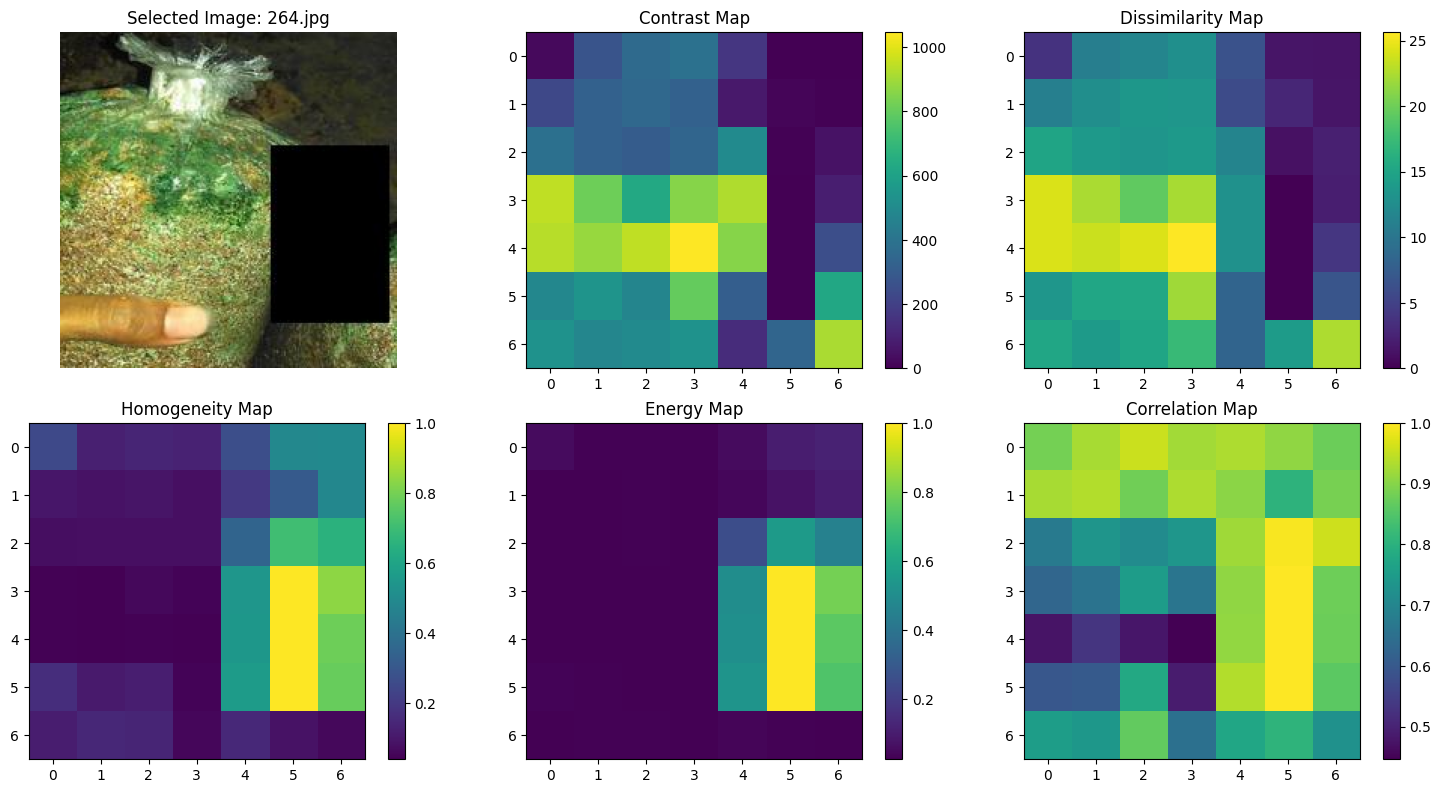

In [ ]:
window_size = 32
distance = 1
angle = 0

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_file = random.choice(image_files)
image_path = os.path.join(folder_path, selected_file)

img = Image.open(image_path).convert('RGB')
gray_img = (255 * rgb2gray(np.array(img))).astype(np.uint8)
h, w = gray_img.shape

feature_maps = {prop: np.zeros((h // window_size, w // window_size)) for prop in props}

for i in range(0, h - window_size + 1, window_size):
    for j in range(0, w - window_size + 1, window_size):
        patch = gray_img[i:i+window_size, j:j+window_size]
        glcm = graycomatrix(patch, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
        for prop in props:
            val = graycoprops(glcm, prop)[0, 0]
            feature_maps[prop][i // window_size, j // window_size] = val

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title(f"Selected Image: {selected_file}")
plt.axis('off')

for idx, prop in enumerate(props):
    plt.subplot(2, 3, idx + 2)
    plt.imshow(feature_maps[prop], cmap='viridis')
    plt.title(f"{prop.capitalize()} Map")
    plt.colorbar()

plt.tight_layout()
plt.show()

<hr>

## **Feature Extraction using ResNet-18 + CBAM**

In [ ]:
import torch, random, numpy as np

df = pd.read_csv(output_csv)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_planes // ratio, in_planes, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).flatten(1))
        max_out = self.fc(self.max_pool(x).flatten(1))
        out = avg_out + max_out
        return self.sigmoid(out).view(b, c, 1, 1)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

In [ ]:
class ResNet18_CBAM_FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            CBAM(64),
            base_model.layer2,
            CBAM(128),
            base_model.layer3,
            CBAM(256),
            base_model.layer4,
            CBAM(512)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return torch.flatten(x, 1)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18_CBAM_FeatureExtractor().to(device)
model.eval()

def extract_deep_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(img_tensor).cpu().squeeze(0).numpy()
    return features

all_features = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['file_name']
    img_path = os.path.join(folder_path, filename)
    features = extract_deep_features(img_path)
    if features is None:
        features = np.zeros(512)
    all_features.append(features)

features_array = np.vstack(all_features)
features_df = pd.DataFrame(features_array, columns=[f'deep_feat_{i}' for i in range(features_array.shape[1])])

df = pd.concat([df, features_df], axis=1)
df.to_csv(output_csv, index=False)
print("Saved updated CSV with deep features.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]
100%|██████████| 510/510 [01:02<00:00,  8.17it/s]


Saved updated CSV with deep features.


<hr>